In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from navigation_game import NavigableNetwork
import scipy
import seaborn as sns
import numpy as np
from vizman import viz
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
viz.set_visual_style()
default_sizes = viz.load_data_from_json("sizes.json")
default_colors = viz.load_data_from_json("colors.json")
default_cmaps = viz.give_colormaps()

In [6]:
default_cmaps

{'db_bw_lr': <matplotlib.colors.LinearSegmentedColormap at 0x127f41810>,
 'nb_bw_dr': <matplotlib.colors.LinearSegmentedColormap at 0x1289fb650>,
 'sg_bw_pi': <matplotlib.colors.LinearSegmentedColormap at 0x1289f8350>,
 'bw_lr': <matplotlib.colors.LinearSegmentedColormap at 0x1289fb550>,
 'bw_db': <matplotlib.colors.LinearSegmentedColormap at 0x128a9f850>,
 'bw_hb': <matplotlib.colors.LinearSegmentedColormap at 0x128a9f790>}

In [5]:
# Create test coordinates matching the paper's example
coords = np.array([
    [1, 1],  # A
    [3, 1],  # B
    [3, 2],  # C
    [1, 5],  # D
])

# Create network and get equilibrium
net = NavigableNetwork(coords)
equilibrium = net.build_nash_equilibrium()

# Print the adjacency matrix
print("Adjacency matrix:")
print(equilibrium.astype(int))


Adjacency matrix:
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


<Axes: >

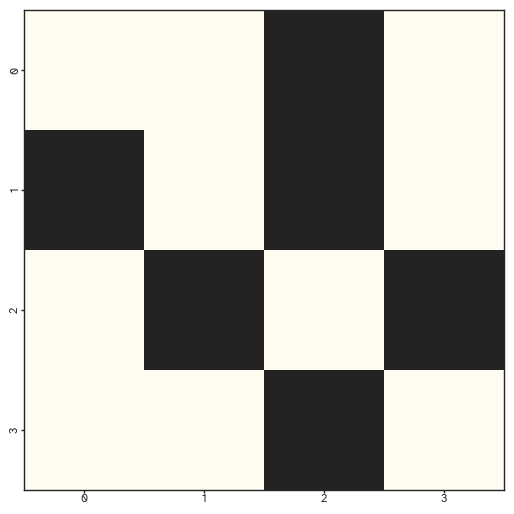

In [7]:
viz.plot_matrix(equilibrium, sns_kwargs={"cmap":default_cmaps["bw_hb"]})

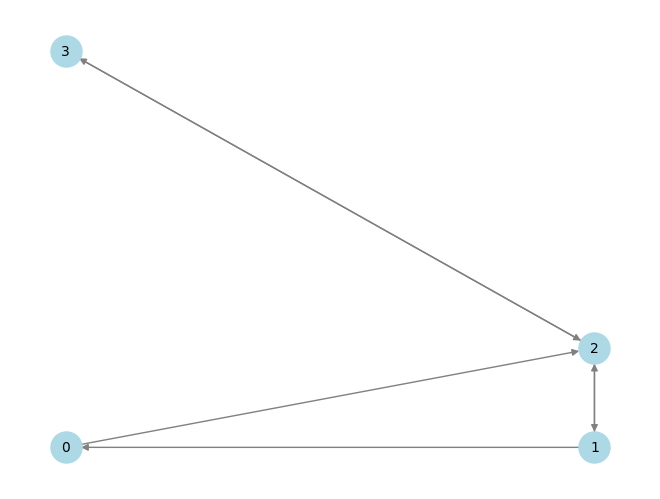

In [ ]:
import networkx as nx

G = nx.from_numpy_array(equilibrium, create_using=nx.DiGraph)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos = coords, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')

In [9]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]


In [10]:
game = NavigableNetwork(coordinates)
nash_network = game.build_nash_equilibrium()

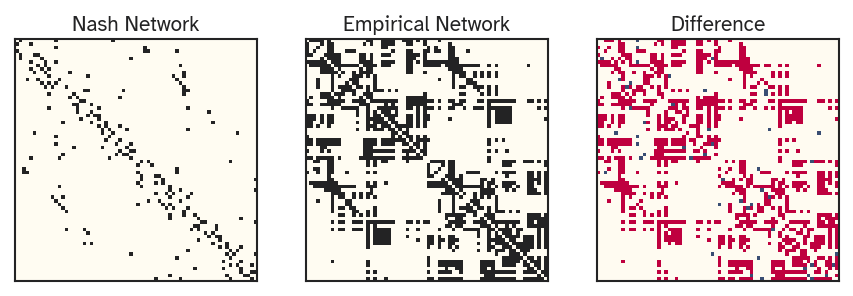

In [21]:
fig, axes = plt.subplot_mosaic([["A", "B","C"]], figsize=viz.cm_to_inch(default_sizes['half_page']), dpi=150)
viz.plot_matrix(nash_network.astype(int), axis=axes["A"], sns_kwargs={"cmap":default_cmaps["bw_hb"], 
                                                                      "xticklabels":False, "yticklabels":False})
viz.plot_matrix(connectivity.astype(int), axis=axes["B"], sns_kwargs={"cmap":default_cmaps["bw_hb"], 
                                                                      "xticklabels":False, "yticklabels":False})
viz.plot_matrix(connectivity.astype(int)-nash_network.astype(int), axis=axes["C"], sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                                                               "xticklabels":False, "yticklabels":False})
axes["A"].set_title("Nash Network")
axes["B"].set_title("Empirical Network")
axes["C"].set_title("Difference");

In [73]:
from navigation_game import NetworkParameters, DevelopingNetwork

# Create parameters
params = NetworkParameters(
    alpha=1.0,
    beta_infinity=1.0,
    tau_beta=50.0,
    t0=1.0,
    tau_t=50.0,
    connectivity_penalty=100.0,
    n_flips_per_iteration=10,
    seed=42
)

# Create network
network = DevelopingNetwork(coordinates, params)

# Run simulation
adjacency_history = network.simulate(n_iterations=300)

In [54]:
adjacency_history.shape

(68, 68, 300)

In [74]:
from scipy.stats import pearsonr

# Initialize the vector to store correlation values
correlation_vector = np.zeros(adjacency_history.shape[2])

# Compute the column-sum of connectivity
connectivity_sum = connectivity.sum(axis=0)

# Iterate over each slice of adjacency_history
for t in range(adjacency_history.shape[2]):
    # Compute the column-sum of the current slice
    adjacency_sum = adjacency_history[:, :, t].sum(axis=0)
    
    # Compute the Pearson correlation
    correlation, _ = pearsonr(adjacency_sum, connectivity_sum)
    
    # Store the correlation value
    correlation_vector[t] = correlation

# Print the correlation vector
print(correlation_vector)

/Users/ICNS/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196
 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196
 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196
 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196
 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196
 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.31000196 -0.26748752
 -0.26748752 -0.27822468 -0.27822468 -0.27822468 -0.27822468 -0.27822468
 -0.27822468 -0.27822468 -0.27822468 -0.27822468 -0.27822468 -0.27822468
 -0.27822468 -0.2789848  -0.2617467  -0.2617467  -0.34084183 -0.30982939
 -0.2792728  -0.29894959 -0.32007545 -0.32007545 -0.32007545 -0.25894628
 -0.25894628 -0.1949141  -0.26185562 -0.26185562 -0

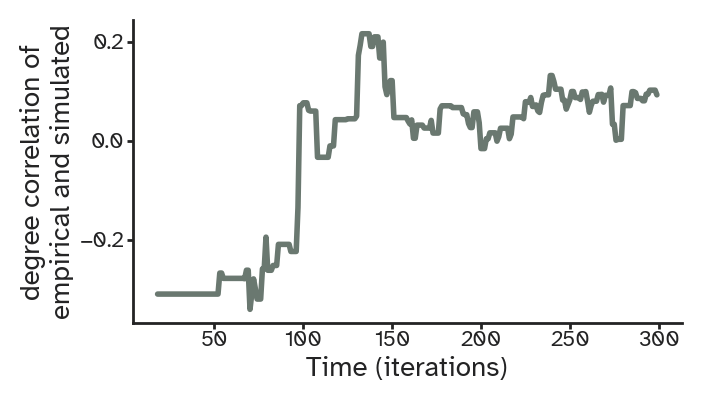

In [75]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(correlation_vector,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("degree correlation of\nempirical and simulated")
sns.despine()

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from numpy.typing import NDArray
from typing import Optional

def animate_network_evolution(coordinates: NDArray[np.float64], 
                            adjacency_history: NDArray[np.int8],
                            interval: int = 50,
                            save_path: Optional[str] = None) -> FuncAnimation:
    """
    Create an animation of network evolution over time.
    
    Args:
        coordinates: Array of shape (n_nodes, 2) containing node coordinates
        adjacency_history: Array of shape (n_nodes, n_nodes, n_timesteps) 
                         containing adjacency matrices at each timestep
        interval: Time between frames in milliseconds
        save_path: Optional path to save animation (e.g., "animation.gif")
    
    Returns:
        matplotlib.animation.FuncAnimation object
    """
    # Setup the figure
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    
    # Create networkx graph
    G = nx.Graph()
    G.add_nodes_from(range(len(coordinates)))
    pos = {i: coordinates[i] for i in range(len(coordinates))}
    
    # Initialize plot elements
    node_collection = nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                           node_size=300, ax=ax)
    edge_collection = nx.draw_networkx_edges(G, pos, ax=ax)
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes,
                       fontsize=12, ha='left', va='top')
    
    # Set animation properties
    node_collection.set_animated(True)
    time_text.set_animated(True)
    
    def update(frame):
        """Update animation for each frame"""
        # Clear current edges
        if len(ax.collections) > 1:
            ax.collections[1].remove()
        
        # Get current adjacency matrix
        adj = adjacency_history[:, :, frame]
        
        # Update edges
        edge_list = [(i, j) for i in range(len(adj)) 
                    for j in range(i+1, len(adj)) if adj[i,j]]
        G.clear_edges()
        G.add_edges_from(edge_list)
        
        # Draw new edges
        edge_collection = nx.draw_networkx_edges(G, pos, ax=ax)
        
        # Update timestep text
        time_text.set_text(f'Timestep: {frame}')
        
        return node_collection, edge_collection, time_text
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=adjacency_history.shape[2],
                        interval=interval)
    
    # Save if path provided
    if save_path:
        anim.save(save_path, writer='pillow')
    
    plt.close()
    return anim

In [63]:
anim = animate_network_evolution(coordinates[:, :2], adjacency_history, save_path='network_evolution.gif')